<a href="https://colab.research.google.com/github/tj07-dev/notebooks/blob/main/Exercise_Model_training.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Imports

In [ ]:
import os
import numpy as np
import utils
import plotting
import pandas as pd
import tensorflow as tf
from tensorflow import keras
import numpy as np
import os
from keras import optimizers
# from keras.utils import to_categorical
from tensorflow.keras.utils import to_categorical
from keras.callbacks import ModelCheckpoint
from keras import regularizers
import matplotlib.pyplot as plt

# Output Class Setup

In [ ]:
import requests
from io import BytesIO
from zipfile import ZipFile
import os

# URL of the dataset zip file
url = "https://s3.eu-west-2.amazonaws.com/vradu.uk/mm-fit.zip"

# Define the target directory for the data
target_dir = "/content/data"

# Create the target directory if it does not exist
os.makedirs(target_dir, exist_ok=True)

# Download the zip file
response = requests.get(url)
zip_file = ZipFile(BytesIO(response.content))

# Extract the contents to the target directory
zip_file.extractall(target_dir)

# Close the zip file
zip_file.close()

print("Dataset downloaded and extracted successfully.")


Dataset downloaded and extracted successfully.


In [ ]:
# encodings for labels in dataset
classes = ['squats', 'lunges', 'bicep_curls', 'situps',
        'pushups', 'tricep_extensions', 'dumbbell_rows',
        'jumping_jacks', 'dumbbell_shoulder_press',
        'lateral_shoulder_raises']
d={}
for i,ex in enumerate(classes):
    d[ex] = i
d

{'squats': 0,
 'lunges': 1,
 'bicep_curls': 2,
 'situps': 3,
 'pushups': 4,
 'tricep_extensions': 5,
 'dumbbell_rows': 6,
 'jumping_jacks': 7,
 'dumbbell_shoulder_press': 8,
 'lateral_shoulder_raises': 9}

# Data Prep

In [ ]:
import pandas as pd
def prepare_dataset(files, data_path):
    """
    Prepare the dataset using the files provided
    """
    from tqdm import tqdm

    df = pd.DataFrame()

    for w_id in tqdm(files):
        data_dir = os.path.join(data_path, w_id)
        t = utils.load_modality(os.path.join(data_dir, w_id + '_pose_2d.npy'))
        t2_frame = t.transpose(1,0,2).reshape(-1,38)

        # Creating nparray for ylabels
        y = []
        labels = utils.load_labels(os.path.join(data_dir, w_id + '_labels.csv'))
        for label in tqdm(labels):
            f1, f2, rep, lbl = label
            for frame in range(f1, f2+1):
                y.append([frame, d[lbl]])
        y = np.array(y)
        y_df = pd.DataFrame(y)

        # Frame appears twice. Once at the beginning (index 0) and once at pos 19. We don't need the second one.
        t2_df=pd.DataFrame(t2_frame).drop(19, axis=1)
        # Removing noise from data
        # We will only retain the rows in the dataframe for which we have labels available.
        # Achieved with inner join
        df = pd.concat([df,t2_df.merge(y_df, how='inner', on=0)])
        print("t2_df :: ",t2_df.shape)
        print("y_df :: ",y_df)
        print("df :: ",df.shape)
    return df

## Building test/train files

In [ ]:
train_files = ['01', '02', '03', '04', '06', '07', '08', '16',
               '17', '18', '14', '15', '19', '20', '12', '13']
train_file_names = list(map(lambda x : 'w' + x, train_files))
print(train_file_names)
test_files = ['05', '09', '10', '11']
test_file_names = list(map(lambda x : 'w' + x, test_files))
print(test_file_names)
val_files = ['00']
val_file_names = list(map(lambda x : 'w' + x, val_files))
print(val_file_names)
data_path = 'data/mm-fit/'
train_df = prepare_dataset(train_file_names, data_path)
test_df = prepare_dataset(test_file_names, data_path)
np.savetxt("ff.csv",test_df, delimiter=',')
val_df = prepare_dataset(val_file_names, data_path)

# print(train_df.shape)
# print(test_df.shape)
# print(val_df.shape)

['w01', 'w02', 'w03', 'w04', 'w06', 'w07', 'w08', 'w16', 'w17', 'w18', 'w14', 'w15', 'w19', 'w20', 'w12', 'w13']
['w05', 'w09', 'w10', 'w11']
['w00']


100%|██████████| 32/32 [00:00<00:00, 5122.81it/s]


t2_df ::  (73183, 37)
y_df ::             0  1
0       2113  0
1       2114  0
2       2115  0
3       2116  0
4       2117  0
...      ... ..
18565  74525  7
18566  74526  7
18567  74527  7
18568  74528  7
18569  74529  7

[18570 rows x 2 columns]
df ::  (18570, 38)



 12%|█▎        | 2/16 [00:00<00:01, 13.92it/s]

t2_df ::  (73546, 37)
y_df ::             0  1
0       2495  0
1       2496  0
2       2497  0
3       2498  0
4       2499  0
...      ... ..
19569  75800  7
19570  75801  7
19571  75802  7
19572  75803  7
19573  75804  7

[19574 rows x 2 columns]
df ::  (38134, 38)



100%|██████████| 30/30 [00:00<00:00, 5516.40it/s]


t2_df ::  (62383, 37)
y_df ::             0  1
0       3803  0
1       3804  0
2       3805  0
3       3806  0
4       3807  0
...      ... ..
16822  65056  7
16823  65057  7
16824  65058  7
16825  65059  7
16826  65060  7

[16827 rows x 2 columns]
df ::  (54961, 38)



 25%|██▌       | 4/16 [00:00<00:00, 15.01it/s]

t2_df ::  (56130, 37)
y_df ::             0  1
0       2899  0
1       2900  0
2       2901  0
3       2902  0
4       2903  0
...      ... ..
15188  52810  2
15189  52811  2
15190  52812  2
15191  52813  2
15192  52814  2

[15193 rows x 2 columns]
df ::  (70154, 38)



100%|██████████| 30/30 [00:00<00:00, 4174.13it/s]


t2_df ::  (54027, 37)
y_df ::             0  1
0       1874  0
1       1875  0
2       1876  0
3       1877  0
4       1878  0
...      ... ..
17553  55378  7
17554  55379  7
17555  55380  7
17556  55381  7
17557  55382  7

[17558 rows x 2 columns]
df ::  (87712, 38)



 38%|███▊      | 6/16 [00:00<00:00, 14.10it/s]

t2_df ::  (70556, 37)
y_df ::             0  1
0       2750  0
1       2751  0
2       2752  0
3       2753  0
4       2754  0
...      ... ..
19659  72489  7
19660  72490  7
19661  72491  7
19662  72492  7
19663  72493  7

[19664 rows x 2 columns]
df ::  (107376, 38)



100%|██████████| 32/32 [00:00<00:00, 2425.33it/s]


t2_df ::  (57193, 37)
y_df ::             0  1
0       1978  0
1       1979  0
2       1980  0
3       1981  0
4       1982  0
...      ... ..
19010  58767  7
19011  58768  7
19012  58769  7
19013  58770  7
19014  58771  7

[19015 rows x 2 columns]
df ::  (126391, 38)



 50%|█████     | 8/16 [00:00<00:00,  8.59it/s]

t2_df ::  (77491, 37)
y_df ::             0  1
0       3772  0
1       3773  0
2       3774  0
3       3775  0
4       3776  0
...      ... ..
22034  80396  7
22035  80397  7
22036  80398  7
22037  80399  7
22038  80400  7

[22039 rows x 2 columns]
df ::  (148430, 38)



100%|██████████| 34/34 [00:00<00:00, 4761.16it/s]


t2_df ::  (64927, 37)
y_df ::             0  1
0       2295  0
1       2296  0
2       2297  0
3       2298  0
4       2299  0
...      ... ..
18340  66616  7
18341  66617  7
18342  66618  7
18343  66619  7
18344  66620  7

[18345 rows x 2 columns]
df ::  (166775, 38)



 62%|██████▎   | 10/16 [00:01<00:00,  8.80it/s]

t2_df ::  (120252, 37)
y_df ::              0  1
0        1785  0
1        1786  0
2        1787  0
3        1788  0
4        1789  0
...       ... ..
18730  121608  7
18731  121609  7
18732  121610  7
18733  121611  7
18734  121612  7

[18735 rows x 2 columns]
df ::  (185510, 38)



100%|██████████| 30/30 [00:00<00:00, 4909.26it/s]


t2_df ::  (47997, 37)
y_df ::             0  1
0       1626  0
1       1627  0
2       1628  0
3       1629  0
4       1630  0
...      ... ..
17247  49210  7
17248  49211  7
17249  49212  7
17250  49213  7
17251  49214  7

[17252 rows x 2 columns]
df ::  (202762, 38)



 75%|███████▌  | 12/16 [00:01<00:00,  9.50it/s]

t2_df ::  (56703, 37)
y_df ::             0  1
0       4078  0
1       4079  0
2       4080  0
3       4081  0
4       4082  0
...      ... ..
19471  59636  7
19472  59637  7
19473  59638  7
19474  59639  7
19475  59640  7

[19476 rows x 2 columns]
df ::  (222238, 38)



100%|██████████| 26/26 [00:00<00:00, 4376.26it/s]


t2_df ::  (51561, 37)
y_df ::             0  1
0       1014  0
1       1015  0
2       1016  0
3       1017  0
4       1018  0
...      ... ..
17315  52556  9
17316  52557  9
17317  52558  9
17318  52559  9
17319  52560  9

[17320 rows x 2 columns]
df ::  (239558, 38)



 88%|████████▊ | 14/16 [00:01<00:00,  9.42it/s]

t2_df ::  (93282, 37)
y_df ::             0  1
0       2178  0
1       2179  0
2       2180  0
3       2181  0
4       2182  0
...      ... ..
19793  94865  7
19794  94866  7
19795  94867  7
19796  94868  7
19797  94869  7

[19798 rows x 2 columns]
df ::  (259355, 38)



100%|██████████| 22/22 [00:00<00:00, 4252.49it/s]


t2_df ::  (67787, 37)
y_df ::             0  1
0       5812  0
1       5813  0
2       5814  0
3       5815  0
4       5816  0
...      ... ..
10883  70463  2
10884  70464  2
10885  70465  2
10886  70466  2
10887  70467  2

[10888 rows x 2 columns]
df ::  (270243, 38)



100%|██████████| 16/16 [00:01<00:00,  9.01it/s]


t2_df ::  (68561, 37)
y_df ::             0  1
0       5487  0
1       5488  0
2       5489  0
3       5490  0
4       5491  0
...      ... ..
15129  73020  7
15130  73021  7
15131  73022  7
15132  73023  7
15133  73024  7

[15134 rows x 2 columns]
df ::  (285377, 38)


100%|██████████| 30/30 [00:00<00:00, 7104.17it/s]


t2_df ::  (57157, 37)
y_df ::             0  1
0       2830  0
1       2831  0
2       2832  0
3       2833  0
4       2834  0
...      ... ..
14409  59152  7
14410  59153  7
14411  59154  7
14412  59155  7
14413  59156  7

[14414 rows x 2 columns]
df ::  (14414, 38)



 50%|█████     | 2/4 [00:00<00:00, 13.02it/s]

t2_df ::  (104797, 37)
y_df ::              0  1
0        3755  0
1        3756  0
2        3757  0
3        3758  0
4        3759  0
...       ... ..
19489  107378  7
19490  107379  7
19491  107380  7
19492  107381  7
19493  107382  7

[19494 rows x 2 columns]
df ::  (33908, 38)



100%|██████████| 30/30 [00:00<00:00, 4469.47it/s]


t2_df ::  (76926, 37)
y_df ::             0  1
0       2704  0
1       2705  0
2       2706  0
3       2707  0
4       2708  0
...      ... ..
19009  79012  7
19010  79013  7
19011  79014  7
19012  79015  7
19013  79016  7

[19014 rows x 2 columns]
df ::  (52922, 38)



100%|██████████| 4/4 [00:00<00:00, 13.21it/s]

t2_df ::  (61989, 37)
y_df ::             0  1
0       3062  0
1       3063  0
2       3064  0
3       3065  0
4       3066  0
...      ... ..
20906  64386  7
20907  64387  7
20908  64388  7
20909  64389  7
20910  64390  7

[20911 rows x 2 columns]
df ::  (73833, 38)



100%|██████████| 1/1 [00:00<00:00, 16.02it/s]

t2_df ::  (63918, 37)
y_df ::             0  1
0       4040  0
1       4041  0
2       4042  0
3       4043  0
4       4044  0
...      ... ..
14548  67646  7
14549  67647  7
14550  67648  7
14551  67649  7
14552  67650  7

[14553 rows x 2 columns]
df ::  (14543, 38)


In [ ]:
train_df

,0,1_x,2,3,4,5,6,7,8,9,...,29,30,31,32,33,34,35,36,37,1_y
0,2113.0,654.830,645.013,596.084,586.238,645.049,690.085,715.648,729.248,601.922,...,541.224,692.058,398.234,541.270,684.261,141.536,145.412,151.3510,153.287,0
1,2114.0,652.972,645.013,596.068,586.238,647.039,690.085,717.521,729.276,601.872,...,541.224,692.069,400.164,541.270,684.265,141.559,145.413,151.4140,153.355,0
2,2115.0,652.972,645.013,596.068,586.255,648.867,690.088,723.402,729.290,599.967,...,541.235,692.077,402.130,541.270,684.265,145.465,147.368,157.2290,161.073,0
3,2116.0,652.972,645.013,596.068,586.265,648.918,690.088,725.313,729.392,598.040,...,550.976,692.091,413.893,545.177,684.275,147.526,149.386,163.1640,164.981,0
4,2117.0,652.972,645.080,596.084,586.278,648.922,690.119,725.313,731.223,594.121,...,554.898,693.971,423.685,552.984,684.284,157.246,159.194,169.0110,170.942,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15129,73020.0,778.285,807.620,758.706,760.620,762.602,856.659,872.314,870.430,776.280,...,431.538,543.159,321.763,431.573,550.984,104.342,102.412,31.8117,100.349,7
15130,73021.0,778.285,807.633,758.706,760.638,762.607,856.667,872.300,870.430,776.280,...,435.397,543.237,321.763,435.465,549.047,104.342,102.412,31.8117,100.349,7
15131,73022.0,778.285,807.633,758.706,760.656,762.630,856.698,872.300,870.468,776.280,...,435.397,543.237,321.786,435.465,549.047,104.358,102.388,31.8117,100.460,7
15132,73023.0,778.286,807.639,758.729,760.668,762.648,856.706,872.314,870.468,776.280,...,435.397,543.237,321.786,435.465,549.047,104.383,102.388,31.8117,100.460,7


In [ ]:
test_df.head()

,0,1_x,2,3,4,5,6,7,8,9,...,29,30,31,32,33,34,35,36,37,1_y
0,2830.0,554.996,556.818,494.154,449.190,478.490,619.509,660.750,633.292,519.641,...,519.693,654.888,396.193,509.893,654.865,151.430,151.433,151.394,153.295,0
1,2831.0,554.996,556.818,494.154,449.190,478.525,617.632,660.750,631.255,519.687,...,519.693,656.775,398.133,509.893,656.840,163.141,163.163,163.141,163.139,0
2,2832.0,554.996,556.886,494.297,449.190,490.223,617.632,660.709,617.672,519.687,...,519.693,656.784,404.078,511.825,658.786,190.483,188.608,192.519,190.508,0
3,2833.0,554.996,556.895,496.123,449.190,490.224,617.632,660.704,617.672,521.608,...,519.693,656.836,404.083,511.826,658.786,190.484,188.609,192.519,190.508,0
4,2834.0,556.809,556.897,496.193,453.055,494.220,617.632,658.763,613.705,521.628,...,519.694,656.838,415.799,513.799,658.786,204.253,204.261,208.187,208.118,0


## Saving train, test, val set

In [ ]:
# Saving X data for training and testing
np.savetxt(
    'data/X_train.txt',
    train_df.iloc[:,1:-1].values,
    fmt = '%1.3f',
    delimiter = ','
)
np.savetxt(
    'data/X_test.txt',
    test_df.iloc[:,1:-1].values,
    fmt = '%1.3f',
    delimiter = ','
)
np.savetxt(
    'data/X_val.txt',
    val_df.iloc[:,1:-1].values,
    fmt = '%1.3f',
    delimiter = ','
)

In [ ]:
# Saving Y data for training and testing
np.savetxt(
    'data/Y_train.txt',
    train_df.iloc[:,-1].values,
    fmt = '%d',
    delimiter = ','
)
np.savetxt(
    'data/Y_test.txt',
    test_df.iloc[:,-1].values,
    fmt = '%d',
    delimiter = ','
)
np.savetxt(
    'data/Y_val.txt',
    val_df.iloc[:,-1].values,
    fmt = '%d',
    delimiter = ','
)

## Data Loading Functions

In [ ]:
def load_X(X_path):
    file = open(X_path, 'r')
    X_ = np.array(
        [elem for elem in [
            row.split(',') for row in file
        ]],
        dtype=np.float32
    )
    file.close()
    return X_

def load_Y(y_path):
    file = open(y_path, 'r')
    y_ = np.array(
        [elem for elem in [
            row.replace('  ', ' ').strip().split(' ') for row in file
        ]],
        dtype=np.int32
    )
    file.close()
    return y_

## Estimation functions

In [ ]:
def euclidean_dist(a, b):
    # This function calculates the euclidean distance between 2 point in 2-D coordinates
    # if one of two points is (0,0), dist = 0
    # a, b: input array with dimension: m, 2
    # m: number of samples
    # 2: x and y coordinate
    try:
        if (a.shape[1] == 2 and a.shape == b.shape):
            # check if element of a and b is (0,0)
            bol_a = (a[:,0] != 0).astype(int)
            bol_b = (b[:,0] != 0).astype(int)
            dist = np.linalg.norm(a-b, axis=1)
            return((dist*bol_a*bol_b).reshape(a.shape[0],1))
    except:
        print("[Error]: Check dimension of input vector")
        return 0

## Normalization

In [ ]:
def norm_X(X):
    num_sample = X.shape[0]
    # Keypoints
    Nose = X[:,0*2:0*2+2]
    Neck = X[:,1*2:1*2+2]
    RShoulder = X[:,2*2:2*2+2]
    RElbow = X[:,3*2:3*2+2]
    RWrist = X[:,4*2:4*2+2]
    LShoulder = X[:,5*2:5*2+2]
    LElbow = X[:,6*2:6*2+2]
    LWrist = X[:,7*2:7*2+2]
    RHip = X[:,8*2:8*2+2]
    RKnee = X[:,9*2:9*2+2]
    RAnkle = X[:,10*2:10*2+2]
    LHip = X[:,11*2:11*2+2]
    LKnee = X[:,12*2:12*2+2]
    LAnkle = X[:,13*2:13*2+2]
    REye = X[:,14*2:14*2+2]
    LEye = X[:,15*2:15*2+2]
    REar = X[:,16*2:16*2+2]
    LEar = X[:,17*2:17*2+2]

    # Length of head
    length_Neck_LEar = euclidean_dist(Neck, LEar)
    length_Neck_REar = euclidean_dist(Neck, REar)
    length_Neck_LEye = euclidean_dist(Neck, LEye)
    length_Neck_REye = euclidean_dist(Neck, REye)
    length_Nose_LEar = euclidean_dist(Nose, LEar)
    length_Nose_REar = euclidean_dist(Nose, REar)
    length_Nose_LEye = euclidean_dist(Nose, LEye)
    length_Nose_REye = euclidean_dist(Nose, REye)
    length_head      = np.maximum.reduce([length_Neck_LEar, length_Neck_REar, length_Neck_LEye, length_Neck_REye, \
                                 length_Nose_LEar, length_Nose_REar, length_Nose_LEye, length_Nose_REye])
    #length_head      = np.sqrt(np.square((LEye[:,0:1]+REye[:,0:1])/2 - Neck[:,0:1]) + np.square((LEye[:,1:2]+REye[:,1:2])/2 - Neck[:,1:2]))

    # Length of torso
    length_Neck_LHip = euclidean_dist(Neck, LHip)
    length_Neck_RHip = euclidean_dist(Neck, RHip)
    length_torso     = np.maximum(length_Neck_LHip, length_Neck_RHip)
    #length_torso     = np.sqrt(np.square(Neck[:,0:1]-(LHip[:,0:1]+RHip[:,0:1])/2) + np.square(Neck[:,1:2]-(LHip[:,1:2]+RHip[:,1:2])/2))

    # Length of right leg
    length_leg_right = euclidean_dist(RHip, RKnee) + euclidean_dist(RKnee, RAnkle)
    #length_leg_right = np.sqrt(np.square(RHip[:,0:1]-RKnee[:,0:1]) + np.square(RHip[:,1:2]-RKnee[:,1:2])) \
    #+ np.sqrt(np.square(RKnee[:,0:1]-RAnkle[:,0:1]) + np.square(RKnee[:,1:2]-RAnkle[:,1:2]))

    # Length of left leg
    length_leg_left = euclidean_dist(LHip, LKnee) + euclidean_dist(LKnee, LAnkle)
    #length_leg_left = np.sqrt(np.square(LHip[:,0:1]-LKnee[:,0:1]) + np.square(LHip[:,1:2]-LKnee[:,1:2])) \
    #+ np.sqrt(np.square(LKnee[:,0:1]-LAnkle[:,0:1]) + np.square(LKnee[:,1:2]-LAnkle[:,1:2]))

    # Length of leg
    length_leg = np.maximum(length_leg_right, length_leg_left)

    # Length of body
    length_body = length_head + length_torso + length_leg

    # Check all samples have length_body of 0
    length_chk = (length_body > 0).astype(int)

    # Check keypoints at origin
    keypoints_chk = (X > 0).astype(int)

    chk = length_chk * keypoints_chk

    # Set all length_body of 0 to 1 (to avoid division by 0)
    length_body[length_body == 0] = 1

    # The center of gravity
    # number of point OpenPose locates:
    num_pts = (X[:, 0::2] > 0).sum(1).reshape(num_sample,1)
    centr_x = X[:, 0::2].sum(1).reshape(num_sample,1) / num_pts
    centr_y = X[:, 1::2].sum(1).reshape(num_sample,1) / num_pts

    # The  coordinates  are  normalized relative to the length of the body and the center of gravity
    X_norm_x = (X[:, 0::2] - centr_x) / length_body
    X_norm_y = (X[:, 1::2] - centr_y) / length_body

    # Stack 1st element x and y together
    X_norm = np.column_stack((X_norm_x[:,:1], X_norm_y[:,:1]))

    for i in range(1, X.shape[1]//2):
        X_norm = np.column_stack((X_norm, X_norm_x[:,i:i+1], X_norm_y[:,i:i+1]))

    # Set all samples have length_body of 0 to origin (0, 0)
    X_norm = X_norm * chk

    return X_norm

## Plotting Functions

In [ ]:
def plot_line(a, b):
    if (a.any()> 0 and b.any()>0): plt.plot([a[0], b[0]], [a[1], b[1]], 'k-')

def plot_skeleton(sample, pattern):
    for i in range(len(sample)//2):
        plt.plot(sample[i*2], sample[i*2+1], pattern)
    skeleton = sample.reshape(1, 36)
    Nose = skeleton[:,0*2:0*2+2][0]
    Neck = skeleton[:,1*2:1*2+2][0]
    RShoulder = skeleton[:,2*2:2*2+2][0]
    RElbow = skeleton[:,3*2:3*2+2][0]
    RWrist = skeleton[:,4*2:4*2+2][0]
    LShoulder = skeleton[:,5*2:5*2+2][0]
    LElbow = skeleton[:,6*2:6*2+2][0]
    LWrist = skeleton[:,7*2:7*2+2][0]
    RHip = skeleton[:,8*2:8*2+2][0]
    RKnee = skeleton[:,9*2:9*2+2][0]
    RAnkle = skeleton[:,10*2:10*2+2][0]
    LHip = skeleton[:,11*2:11*2+2][0]
    LKnee = skeleton[:,12*2:12*2+2][0]
    LAnkle = skeleton[:,13*2:13*2+2][0]
    REye = skeleton[:,14*2:14*2+2][0]
    LEye = skeleton[:,15*2:15*2+2][0]
    REar = skeleton[:,16*2:16*2+2][0]
    LEar = skeleton[:,17*2:17*2+2][0]
    #Nose = sample.reshape(1, 36)[:,0*2:0*2+2][0]
    #Neck = sample.reshape(1, 36)[:,1*2:1*2+2][0]
    plot_line(LEar, LEye)
    plot_line(LEye, Nose)
    plot_line(REar, REye)
    plot_line(REye, Nose)
    plot_line(Nose, Neck)
    plot_line(Neck, LShoulder)
    plot_line(LShoulder, LElbow)
    plot_line(LElbow, LWrist)
    plot_line(Neck, RShoulder)
    plot_line(RShoulder, RElbow)
    plot_line(RElbow, RWrist)
    plot_line(Neck, LHip)
    plot_line(LHip, LKnee)
    plot_line(LKnee, LAnkle)
    plot_line(Neck, RHip)
    plot_line(RHip, RKnee)
    plot_line(RKnee, RAnkle)

def plot(sample):
    # sample is one-dimension array
    # e.g: (36,)
    if sample.shape[0] == 36:
        sample_norm = norm_X(sample.reshape(1,36))[0]

        # Plot original coordinates
        pad_ori = 40
        plt.figure(str(sample))
        plt.subplot(121)
        plt.title('Original skeleton')
        X_ori = sample
        x_max = max(X_ori[0::2]) + pad_ori
        x_min = min(i for i in X_ori[0::2] if i > 0) - pad_ori
        y_max = max(X_ori[1::2]) + pad_ori
        y_min = min(j for j in X_ori[1::2] if j > 0) - pad_ori
        plt.xlim(x_min,x_max)
        plt.ylim(y_max, y_min)
        plot_skeleton(X_ori, 'bo')

        # Plot normalized coordinates
        pad_nor = 0.2
        #plt.figure(2)
        plt.subplot(122)
        plt.title('Normalized skeleton')
        X_nor = sample_norm
        x_max = max(X_nor[0::2]) + pad_nor
        x_min = min(X_nor[0::2]) - pad_nor
        y_max = max(X_nor[1::2]) + pad_nor
        y_min = min(X_nor[1::2]) - pad_nor
        plt.xlim(x_min,x_max)
        plt.ylim(y_max, y_min)
        plot_skeleton(X_nor, 'ro')
    else:
        print("sample is one-dimension array: (36,)")

# Model Training

In [ ]:
# Create a model
model = keras.Sequential([
    keras.layers.Dense(64, activation='sigmoid', input_shape=(36,)),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(32, activation='sigmoid'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(16, activation='sigmoid'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(10, activation='softmax')
])
model.summary()

# plot training log
def plot_history(history):
    history_dict = history.history
    history_dict.keys()
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(1, len(acc) + 1)

    plt.figure(figsize=(16, 9), dpi=80)
    # "bo" is for "blue dot"
    plt.plot(epochs, loss, 'bo', label='Training loss')
    plt.plot(epochs, acc, 'b', label='Training accuracy')
    # b is for "solid blue line"
    plt.plot(epochs, val_loss, 'ro', label='Validation loss')
    plt.plot(epochs, val_acc, 'r', label='Validation accuracy')
    plt.title('Training and validation loss/acc')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 64)                2368      
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense_1 (Dense)             (None, 32)                2080      
                                                                 
 dropout_1 (Dropout)         (None, 32)                0         
                                                                 
 dense_2 (Dense)             (None, 16)                528       
                                                                 
 dropout_2 (Dropout)         (None, 16)                0         
                                                                 
 dense_3 (Dense)             (None, 10)                1

In [ ]:
model.compile(loss=keras.losses.sparse_categorical_crossentropy, optimizer=keras.optimizers.Adam(learning_rate=0.01), metrics=['accuracy'])

In [ ]:
# Load and norminalize dataset
X_train = load_X('data/X_train.txt')
Y_train = load_Y('data/Y_train.txt')
X_train_norm = norm_X(X_train)

X_test = load_X('data/X_test.txt')
Y_test = load_Y('data/Y_test.txt')
X_test_norm = norm_X(X_test)

X_val = load_X('data/X_val.txt')
Y_val = load_Y('data/Y_val.txt')
X_val_norm = norm_X(X_val)

In [ ]:
history = model.fit(
    X_train_norm,
    Y_train,
    validation_data=(X_test_norm, Y_test),
    epochs=20, batch_size=64, verbose=1)

Epoch 1/20
4460/4460 [==============================] - 25s 5ms/step - loss: 1.3837 - accuracy: 0.4344 - val_loss: 0.7837 - val_accuracy: 0.7137
Epoch 2/20
4460/4460 [==============================] - 19s 4ms/step - loss: 0.9832 - accuracy: 0.6100 - val_loss: 0.6405 - val_accuracy: 0.7455
Epoch 3/20
4460/4460 [==============================] - 20s 5ms/step - loss: 0.8829 - accuracy: 0.6554 - val_loss: 0.5511 - val_accuracy: 0.7989
Epoch 4/20
4460/4460 [==============================] - 20s 5ms/step - loss: 0.8260 - accuracy: 0.6821 - val_loss: 0.5051 - val_accuracy: 0.8119
Epoch 5/20
4460/4460 [==============================] - 21s 5ms/step - loss: 0.7797 - accuracy: 0.7120 - val_loss: 0.4526 - val_accuracy: 0.8684
Epoch 6/20
4460/4460 [==============================] - 23s 5ms/step - loss: 0.7394 - accuracy: 0.7311 - val_loss: 0.3830 - val_accuracy: 0.9186
Epoch 7/20
4460/4460 [==============================] - 20s 4ms/step - loss: 0.7163 - accuracy: 0.7431 - val_loss: 0.3781 - val_ac

# Results

In [ ]:
pd.DataFrame(history.history)

,loss,accuracy,val_loss,val_accuracy
0,1.383662,0.434439,0.783714,0.713692
1,0.983197,0.609979,0.640481,0.745493
2,0.882927,0.655407,0.551121,0.798911
3,0.825971,0.682059,0.505077,0.811886
4,0.779676,0.712027,0.452597,0.868446
5,0.739387,0.731086,0.383030,0.918641
6,0.716306,0.743066,0.378105,0.901467
7,0.697463,0.751098,0.351382,0.910298
8,0.682530,0.757314,0.340592,0.910379
9,0.674621,0.760419,0.332826,0.919697


from matplotlib import pyplot as plt
_df_0['index'].plot(kind='hist', bins=20, title='index')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_1['loss'].plot(kind='hist', bins=20, title='loss')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_2['accuracy'].plot(kind='hist', bins=20, title='accuracy')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_3['val_loss'].plot(kind='hist', bins=20, title='val_loss')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_4.plot(kind='scatter', x='index', y='loss', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_5.plot(kind='scatter', x='loss', y='accuracy', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_6.plot(kind='scatter', x='accuracy', y='val_loss', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_7.plot(kind='scatter', x='val_loss', y='val_accuracy', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  from matplotlib import pyplot as plt
  import seaborn as sns
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['index']
  ys = series['loss']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_8.sort_values('index', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('index')
_ = plt.ylabel('loss')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  from matplotlib import pyplot as plt
  import seaborn as sns
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['index']
  ys = series['accuracy']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_9.sort_values('index', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('index')
_ = plt.ylabel('accuracy')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  from matplotlib import pyplot as plt
  import seaborn as sns
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['index']
  ys = series['val_loss']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_10.sort_values('index', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('index')
_ = plt.ylabel('val_loss')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  from matplotlib import pyplot as plt
  import seaborn as sns
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['index']
  ys = series['val_accuracy']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_11.sort_values('index', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('index')
_ = plt.ylabel('val_accuracy')

from matplotlib import pyplot as plt
_df_12['index'].plot(kind='line', figsize=(8, 4), title='index')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_13['loss'].plot(kind='line', figsize=(8, 4), title='loss')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_14['accuracy'].plot(kind='line', figsize=(8, 4), title='accuracy')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_15['val_loss'].plot(kind='line', figsize=(8, 4), title='val_loss')
plt.gca().spines[['top', 'right']].set_visible(False)

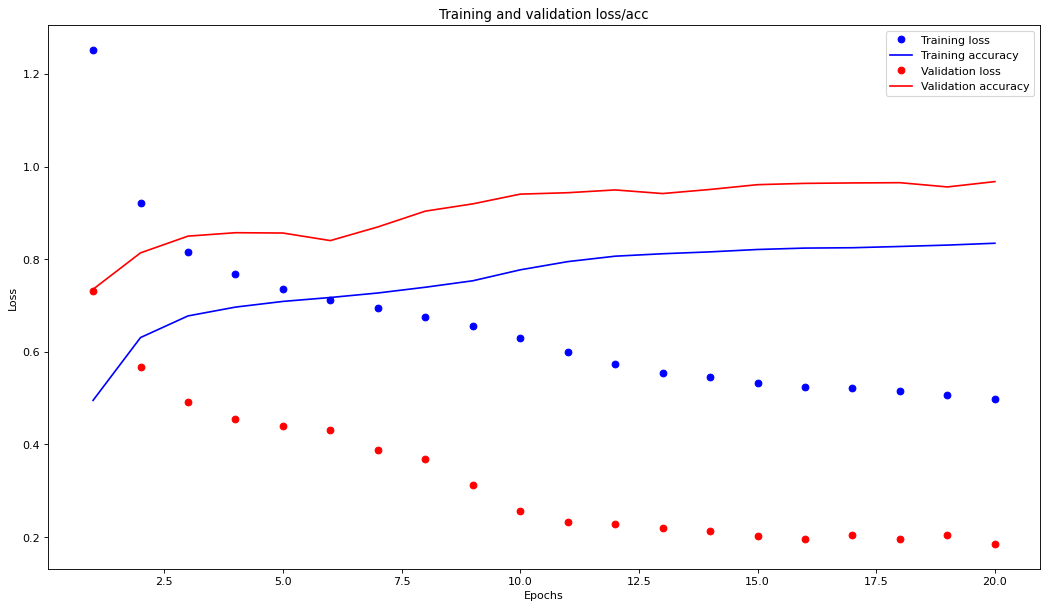

In [ ]:
plot_history(history)

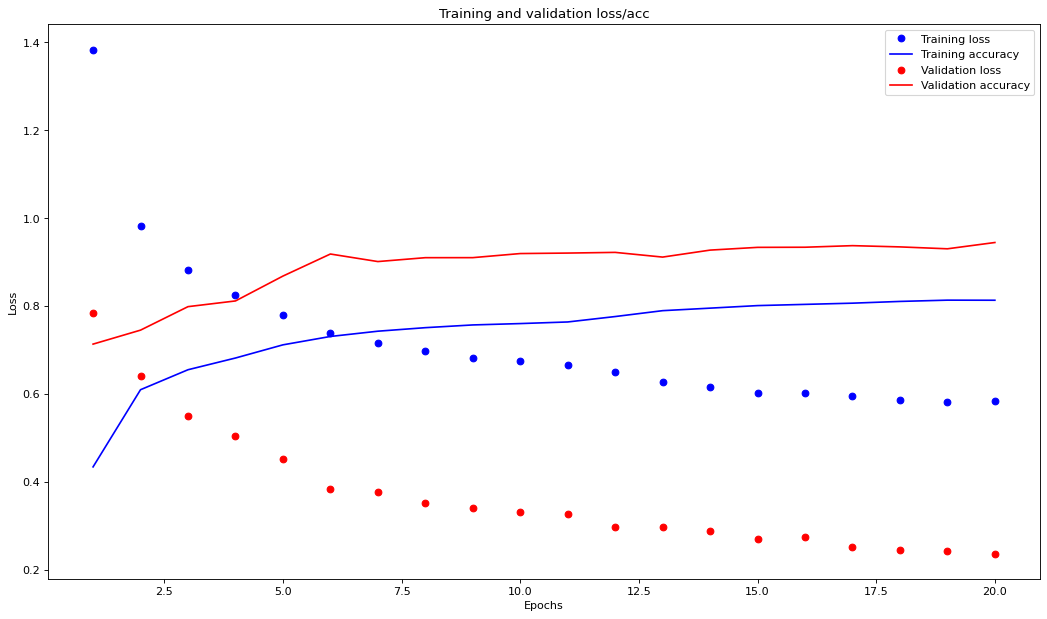

In [ ]:
plot_history(history)

In [ ]:
# save model
model.save('pose.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
# load model
model = tf.keras.models.load_model('pose.h5')

# Random Testing

1/1 [==============================] - 0s 29ms/step
Estimated pose:
squats: 	0.0001515471
lunges: 	0.8700867
bicep_curls: 	0.0164042
situps: 	2.2703334e-06
pushups: 	0.0033971122
tricep_extensions: 	1.4695675e-25
dumbbell_rows: 	0.10559572
jumping_jacks: 	0.0026644338
dumbbell_shoulder_press: 	1.43466e-10
lateral_shoulder_raises: 	0.001697969

Prediction: lunges
Actual Label :lunges


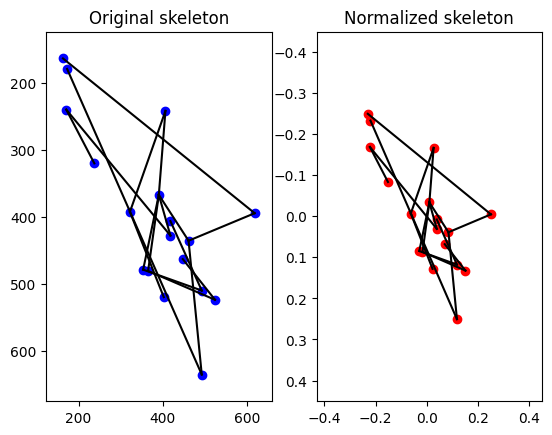

In [ ]:
# Testing on single example
LABELS = list(d.keys())
ind = np.random.randint(0,70000)
X_sample = load_X('data/X_test.txt')[ind:2+ind]
X_sample_norm = norm_X(X_sample)
y_out = model.predict(X_sample_norm[1].reshape(1, 36))

print("Estimated pose:")
for idx in range(len(LABELS)):
    print(LABELS[idx] + ": \t" + str(y_out[0][idx]))
plot(X_sample[1])
print('\nPrediction: ',end='')
print(LABELS[np.argmax(y_out)])
print('Actual Label :', end='')
print(LABELS[int(load_Y('data/Y_test.txt')[ind])])

In [ ]:
y_out.max()

0.8700867

# Evaluation on Held Out Data

In [ ]:
model.evaluate(
    X_val_norm,
    Y_val,
    verbose=1
)

455/455 [==============================] - 1s 3ms/step - loss: 0.2476 - accuracy: 0.9594


[0.2475929856300354, 0.9593619108200073]

# TF Lite Conversion

In [ ]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()
# Save the model.
with open('pose.tflite', 'wb') as f:
  f.write(tflite_model)

In [ ]:
# Load the TFLite model and allocate tensors.
interpreter = tf.lite.Interpreter(model_path='pose.tflite')
interpreter.allocate_tensors()

# Get input and output tensors.
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

# Setup input
X_sample = load_X('data/X_test.txt')[0+1234].reshape(1,-1)
X_sample_norm = norm_X(X_sample)

In [ ]:
X_sample

array([[586.167, 586.247, 525.52 , 480.556, 554.919, 645.017, 686.225,
        621.596, 541.314, 494.274, 490.212, 623.514, 666.689, 656.837,
        572.501, 598.057, 556.825, 617.533, 186.653, 251.303, 245.461,
        337.549, 288.424, 255.161, 347.232, 288.383, 415.846, 525.507,
        668.598, 413.869, 521.653, 666.673, 174.888, 176.802, 180.777,
        180.831]], dtype=float32)

In [ ]:
X_sample_norm.shape

(1, 36)

In [ ]:
input_details

[{'name': 'serving_default_dense_input:0',
  'index': 0,
  'shape': array([ 1, 36], dtype=int32),
  'shape_signature': array([-1, 36], dtype=int32),
  'dtype': numpy.float32,
  'quantization': (0.0, 0),
  'quantization_parameters': {'scales': array([], dtype=float32),
   'zero_points': array([], dtype=int32),
   'quantized_dimension': 0},
  'sparsity_parameters': {}}]

In [ ]:
# Set up your input data.
input_data = np.array(X_sample_norm[0], np.float32).reshape(1,36)
input_data.shape

(1, 36)

In [ ]:

# Invoke the model on the input data
interpreter.set_tensor(input_details[0]['index'], input_data)
interpreter.invoke()

# Get the result
output_data = interpreter.get_tensor(output_details[0]['index'])
print(output_data)

[[7.7967894e-01 2.8198846e-02 1.1379349e-01 1.3094388e-04 9.1912174e-05
  3.8404579e-03 2.4509083e-03 5.7101347e-02 1.1317516e-02 3.3955735e-03]]


In [ ]:
output_data[0].max()

0.77967894